# Model Training
A number combination of different model architectures, features used, and training approaches were tested:

## Model Architectures
1. Baseline model (avg): return the average `K%` across a pitcher's available data (considering `2021-2022` to predict `2023`)
1. Baseline model (last): return the last seen `K%` across a pitcher's available data (considering `2021-2022` to predict `2023`)
1. Baseline model (xK% article: `xK% = -0.61 + (L/Str * 1.1538) + (S/Str * 1.4696) + (F/Str * 0.9417)` (see [The Definitive Pitcher Expected K% Formula](https://fantasy.fangraphs.com/the-definitive-pitcher-expected-k-formula/)) 
1. [Linear Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
1. [Random Forest Model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
1. [XGBoost Model](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)

## Features
1. All 67 features
    - 31 categorical one-hot features for teams (30 MLB teams and '---' for multi-team)
    - 36 numeric features
1. 7 features selected from Lasso model (see [03-feature-engineering.ipynb](./03-feature-engineering.ipynb))
   - `'numeric__Pit/PA'`
   - `'numeric__Str%'`
   - `'numeric__F/Str'`
   - `'numeric__I/Str'`
   - `'numeric__Con'`
   - `'numeric__30%'`
   - `'numeric__L/SO'`

## Training Approach
- Classical cross-validation approach (5-fold using `2021-2022` to predict `2023`
- Timeseries cross-validation approach (use `2021` to predict `2022` and `2021-2022` to predict `2023`)
- See [02-data-partitioning.ipynb](./02-data-partitioning.ipynb) for more details

**THIS NOTEBOOK USES THE CLASSICAL CROSS-VALIDATION APPROACH**
The classical cross-validation approach will be used to test the various combinations for model architectures and features listed above.

In all cases, the `MSE` (mean squared error) is used to evaluate model performance.

**NOTE**: All pipelines and functions defined in this notebook are defined in source code at `bullpen.model_utils`. They are show here for convenience, but stored in source code for future use and ability to unit test.

In [40]:
import numpy as np
import pandas as pd
import scipy.stats
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

set_config(display="text")

from bullpen import data_utils, model_utils

In [2]:
train = pd.read_csv(data_utils.DATA_DIR.joinpath("train.csv"))
train

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%,Rk,IP,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
0,621345,18655,A.J. Minter,ATL,27,2021,221,0.257919,696,52.1,...,44,7,11,46,0.192982,11,4,0,0,0
1,621345,18655,A.J. Minter,ATL,28,2022,271,0.346863,649,70.0,...,50,2,23,71,0.244681,12,0,0,0,0
2,621345,18655,A.J. Minter,ATL,29,2023,260,0.315385,647,64.2,...,40,4,13,69,0.158537,8,1,0,0,0
3,640462,19343,A.J. Puk,OAK,27,2022,281,0.270463,773,66.1,...,48,6,22,54,0.289474,15,4,0,0,0
4,640462,19343,A.J. Puk,MIA,28,2023,242,0.322314,755,56.2,...,42,6,22,56,0.282051,16,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,425844,1943,Zack Greinke,HOU,37,2021,697,0.172166,417,171.0,...,51,4,34,85,0.285714,13,6,0,0,0
984,425844,1943,Zack Greinke,KCR,38,2022,585,0.124786,396,137.0,...,39,3,22,51,0.301370,7,2,0,0,0
985,425844,1943,Zack Greinke,KCR,39,2023,593,0.163575,353,142.1,...,53,6,25,70,0.263158,11,2,0,0,0
986,668868,25918,Zack Thompson,STL,24,2022,136,0.198529,967,34.2,...,40,3,10,17,0.370370,3,2,0,0,0


In [3]:
target = "K%"
drop_cols = ["Name", target]
lasso_features = [
    "Pit/PA",
    "Str%",
    "F/Str",
    "I/Str",
    "Con",
    "30%",
    "L/SO",
]

X_df = train[[c for c in train.columns if c not in drop_cols]]
X_df_lasso = train[lasso_features]

y_df = train[target]

In [4]:
X_df.head()

,MLBAMID,PlayerId,Team,Age,Season,TBF,Rk,IP,PA,Pit,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
0,621345,18655,ATL,27,2021,221,696,52.1,221,876,...,44,7,11,46,0.192982,11,4,0,0,0
1,621345,18655,ATL,28,2022,271,649,70.0,272,1111,...,50,2,23,71,0.244681,12,0,0,0,0
2,621345,18655,ATL,29,2023,260,647,64.2,260,1062,...,40,4,13,69,0.158537,8,1,0,0,0
3,640462,19343,OAK,27,2022,281,773,66.1,281,1072,...,48,6,22,54,0.289474,15,4,0,0,0
4,640462,19343,MIA,28,2023,242,755,56.2,242,950,...,42,6,22,56,0.282051,16,0,0,0,0


In [5]:
X_df_lasso.head()

,Pit/PA,Str%,F/Str,I/Str,Con,30%,L/SO
0,3.963801,0.660,0.268,0.247,0.687,0.045249,11
1,4.084559,0.669,0.301,0.214,0.668,0.029412,23
2,4.084615,0.658,0.300,0.225,0.685,0.023077,13
3,3.814947,0.655,0.269,0.245,0.708,0.046263,22
4,3.925620,0.684,0.243,0.229,0.670,0.024793,22


In [6]:
y_df.head()

0    0.257919
1    0.346863
2    0.315385
3    0.270463
4    0.322314
Name: K%, dtype: float64

In [7]:
processor = model_utils.make_processing_pipeline(
    categorical_features=["Team"],
    numeric_features=[f for f in X_df.columns if f not in ("Team")],
)

processor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Team']),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['MLBAMID', 'PlayerId', 'Age', 'Season', 'TBF',
                                  'Rk', 'IP', 'PA', 'Pit', 'Pit/PA', 'Str',
                                  'Str%', 'L/Str', 'S/Str', 'F/Str', 'I/Str',
                                  'AS/Str', 'I/Bll', 'AS/Pit', 'Con', '1st%',
                                  '30%', '30c', '30s', '02%', '02c', '02s',
                                  '02h', 'L/SO', 'S/SO', ...])])

In [8]:
processor_lasso = model_utils.make_processing_pipeline(
    categorical_features=None,
    numeric_features=list(X_df_lasso.columns),
)

processor_lasso

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Pit/PA', 'Str%', 'F/Str', 'I/Str', 'Con',
                                  '30%', 'L/SO'])])

## Model training

### Baseline Estimators
Three baseline models were created to level set and see how well simple heuristics could predict player strikeout percentage:
1. Baseline model (avg): return the average K% across a pitcher's available data (considering 2021-2022 to predict 2023)
1. Baseline model (last): return the last seen K% across a pitcher's available data (considering 2021-2022 to predict 2023)
1. Baseline model (`xK% article: xK% = -0.61 + (L/Str * 1.1538) + (S/Str * 1.4696) + (F/Str * 0.9417`) (see [The Definitive Pitcher Expected K% Formula](https://fantasy.fangraphs.com/the-definitive-pitcher-expected-k-formula/))

Any advanced model should beat the performance of these simple heuristics.

In [9]:
results = {}

In [10]:
from sklearn.base import BaseEstimator, RegressorMixin


class Baseline(BaseEstimator, RegressorMixin):
    def __init__(self, method, grouper=None, target="K%"):
        self.method = method
        self.grouper = "PlayerId" if grouper is None else grouper
        self.target = target

    def __repr__(self):
        return f"{__class__.__name__}(method={self.method!r})"

    def fit(self, X, y):
        # Merge features and target for grouping
        data = pd.concat([X, y.rename(self.target)], axis=1)

        # Compute group-level predictions
        if self.method == "last":
            self.best_params_ = "return last seen K%"
            self.group_aggregates_ = (
                data.groupby(self.grouper)[self.target].last().rename("preds")
            )
        elif self.method == "mean":
            self.best_params_ = "return player avg K%"
            self.group_aggregates_ = (
                data.groupby(self.grouper)[self.target].mean().rename("preds")
            )
        else:
            raise ValueError(
                f"Invalid method {self.method!r}. Supported methods are 'last' and 'mean'."
            )
        self.fitted_ = True
        return self

    def predict(self, X):
        if not hasattr(self, "fitted_") or not self.fitted_:
            raise ValueError(
                f"This {self} instance is not fitted yet. Call 'fit' before using this method."
            )

        preds = X.merge(
            self.group_aggregates_,
            left_on=self.grouper,
            right_index=True,
            how="left",
        )

        if preds["preds"].isnull().any():
            raise ValueError("Some groups in X were not seen during fitting.")

        return preds["preds"].to_numpy()


class ArticleModel(BaseEstimator, RegressorMixin):
    """
    See https://fantasy.fangraphs.com/the-definitive-pitcher-expected-k-formula/.
    xK% = -0.61 + (L/Str * 1.1538) + (S/Str * 1.4696) + (F/Str * 0.9417)
    """

    def __repr__(self):
        return f"{__class__.__name__}()"

    def fit(self, X, y):
        self.best_params_ = "return xK% from article"
        self.preds_ = (
            -0.61
            + (X["L/Str"] * 1.1538)
            + (X["S/Str"] * 1.4696)
            + (X["F/Str"] * 0.9417)
        )
        self.fitted_ = True
        return self

    def predict(self, X):
        if not hasattr(self, "fitted_") or not self.fitted_:
            raise ValueError(
                f"This {self} instance is not fitted yet. Call 'fit' before using this method."
            )

        if self.preds_.isnull().any():
            raise ValueError("Some groups in X were not seen during fitting.")

        return self.preds_.to_numpy()


def train_baseline(model, X, y, results):
    model.fit(X, y)
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    score = model.score(X, y)
    params = model.best_params_
    print(f"{model} {params=} {score=:.3f} {mse=:.5f}")
    results[repr(model)] = (score, mse)

    return preds, results

In [11]:
# Baseline 1 heuristic: mean of player performance
baseline_mean_preds, results = train_baseline(
    Baseline(method="mean", grouper="PlayerId", target="K%"),
    X_df,
    y_df,
    results,
)

Baseline(method='mean') params='return player avg K%' score=0.835 mse=0.00053


In [12]:
# Baseline 2 heuristic: last K% seen from a player
baseline_last_preds, results = train_baseline(
    Baseline(method="last", grouper="PlayerId", target="K%"),
    X_df,
    y_df,
    results,
)

Baseline(method='last') params='return last seen K%' score=0.673 mse=0.00104


In [13]:
# Baseline 3 heuristic: formula from article
baseline_article_preds, results = train_baseline(ArticleModel(), X_df, y_df, results)

ArticleModel() params='return xK% from article' score=0.869 mse=0.00042


In [14]:
results

{"Baseline(method='mean')": (0.8346776623757628, 0.0005268612183991187),
 "Baseline(method='last')": (0.6733395134045793, 0.0010410253353765834),
 'ArticleModel()': (0.8690212996753165, 0.00041741242368737753)}

### Non-Baseline Estimators
Now that baselines have been established, more advanced models are create: 
1. [Linear Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
1. [Random Forest Model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
1. [XGBoost Model](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)

For each of the above model architectures, the different feature sets will be tested (All 67 features and 7 lasso features):
1. All 67 features
    - 31 categorical one-hot features for teams (30 MLB teams and '---' for multi-team)
    - 36 numeric features
1. 7 features selected from Lasso model (see [03-feature-engineering.ipynb](./03-feature-engineering.ipynb))
   - `'numeric__Pit/PA'`
   - `'numeric__Str%'`
   - `'numeric__F/Str'`
   - `'numeric__I/Str'`
   - `'numeric__Con'`
   - `'numeric__30%'`
   - `'numeric__L/SO'`

**NOTE**: The `Baseline` models never used the features to make predictions (they only took the mean or last data point from the target variable (`'K%'`). The `ArticleModel` used specific columns with the highest predictive power in the article. Thus, testing performance on two different feature sets didn't make sense. For the remainder of the models, performance will be observed for both the full feature set and the limited lasso feature set.

### Grid Seach Cross Validation (TODO)

In [15]:
def train_model(processor, model, X, y, results, name):
    reg = Pipeline(steps=[("processor", processor), ("regressor", model)])

    reg.fit(X, y)
    preds = reg.predict(X)
    mse = mean_squared_error(y, preds)
    score = reg.score(X, y)
    params = reg.named_steps["regressor"].best_params_
    # name = reg.named_steps["regressor"].best_estimator_.__class__.__name__
    print(f"{name} {params=} {score=:.3f} {mse=:.5f}")
    results[name] = (score, mse)

    return preds, results

#### Logistic Regression

In [16]:
lr_full = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={"fit_intercept": [True, False]},
    cv=5,
)

lr_preds_full, results = train_model(
    processor,
    lr_full,
    X_df,
    y_df,
    results,
    name="LinearRegression(full)",
)

LinearRegression(full) params={'fit_intercept': True} score=0.949 mse=0.00016


In [17]:
lr_feature_impr_full = model_utils.sort_features_by_coefs(
    feature_names=processor.feature_names_in_,
    coefs=lr_full.best_estimator_.coef_,
    print_top_n=5
)

I/Bll 0.00815
IP -0.00552
F/Str -0.00401
TBF 0.00286
L/SO 0.00277


In [18]:
lr_lasso = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={"fit_intercept": [True, False]},
    cv=5,
)

lr_preds_lasso, results = train_model(
    processor_lasso,
    lr_lasso,
    X_df_lasso,
    y_df,
    results,
    name="LinearRegression(lasso)",
)

LinearRegression(lasso) params={'fit_intercept': True} score=0.919 mse=0.00026


In [19]:
lr_feature_impr_lasso = model_utils.sort_features_by_coefs(
    feature_names=processor.feature_names_in_,
    coefs=lr_lasso.best_estimator_.coef_,
    print_top_n=5
)

Age -0.05145
MLBAMID -0.01239
Season -0.01229
TBF -0.00436
Rk 0.00377


#### Random Forest Regressor

In [20]:
rf_full = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={"n_estimators": [25, 50, 100, 150], "max_depth": [5, 10, 15]},
    cv=5,
)

rf_preds_full, results = train_model(
    processor,
    rf_full,
    X_df,
    y_df,
    results,
    name="RandomForestRegressor(full)",
)

RandomForestRegressor(full) params={'max_depth': 15, 'n_estimators': 100} score=0.987 mse=0.00004


In [21]:
rf_feature_impr_full = model_utils.sort_features_by_coefs(
    feature_names=processor.feature_names_in_,
    coefs=rf_full.best_estimator_.feature_importances_,
    print_top_n=5
)

Stru 0.00362
3pK 0.0026
L/SO% 0.00253
Pitu 0.00205
4pW 0.00178


In [22]:
rf_lasso = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={"n_estimators": [25, 50, 100, 150], "max_depth": [5, 10, 15]},
    cv=5,
)

rf_preds_lasso, results = train_model(
    processor_lasso,
    rf_lasso,
    X_df_lasso,
    y_df,
    results,
    name="RandomForestRegressor(lasso)",
)

RandomForestRegressor(lasso) params={'max_depth': 15, 'n_estimators': 100} score=0.987 mse=0.00004


In [23]:
rf_feature_impr_lasso = model_utils.sort_features_by_coefs(
    feature_names=processor.feature_names_in_,
    coefs=rf_lasso.best_estimator_.feature_importances_,
    print_top_n=5
)

Age 0.84433
Season 0.0589
MLBAMID 0.03161
PlayerId 0.02029
TBF 0.01638


#### XGBoost
[xref](https://xgboost.readthedocs.io/en/stable/)
> XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

In [24]:
xgb_full = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid={"n_estimators": [25, 50, 100, 150], "max_depth": [5, 10, 15]},
    cv=5,
)

xgb_preds_full, results = train_model(
    processor,
    xgb_full,
    X_df,
    y_df,
    results,
    name="XGBRegressor(full)",
)

XGBRegressor(full) params={'max_depth': 5, 'n_estimators': 100} score=1.000 mse=0.00000


In [25]:
xgb_feature_impr_full = model_utils.sort_features_by_coefs(
    feature_names=processor.feature_names_in_,
    coefs=xgb_full.best_estimator_.feature_importances_,
    print_top_n=5
)

I/Bll 0.00789
1st% 0.00749
L/SO 0.00645
PA 0.00575
AS/Str 0.00404


In [26]:
xgb_lasso = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid={"n_estimators": [25, 50, 100, 150], "max_depth": [5, 10, 15]},
    cv=5,
)

xgb_preds_lasso, results = train_model(
    processor_lasso,
    xgb_lasso,
    X_df_lasso,
    y_df,
    results,
    name="XGBRegressor(lasso)",
)

XGBRegressor(lasso) params={'max_depth': 5, 'n_estimators': 25} score=0.977 mse=0.00007


In [27]:
xgb_feature_impr_lasso = model_utils.sort_features_by_coefs(
    feature_names=processor.feature_names_in_,
    coefs=xgb_lasso.best_estimator_.feature_importances_,
    print_top_n=5
)

Age 0.63577
Season 0.2896
Rk 0.02299
PlayerId 0.01833
MLBAMID 0.01349


## Conclusion
- The lasso features didn't seem to help much (the full version of every model out performed the lasso version).
- The XGBoost and RandomForest models seem to work the best.
- A simple linear model isn't too bad with `R2=0.948776` and `mse=0.000163`.

In [33]:
results_df = pd.DataFrame(results).T
results_df.columns = ['R2', 'mse']
results_df = results_df.sort_values('mse').round(6)
results_df

,R2,mse
XGBRegressor(full),0.999799,0.000001
RandomForestRegressor(full),0.986832,0.000042
RandomForestRegressor(lasso),0.986812,0.000042
XGBRegressor(lasso),0.976780,0.000074
LinearRegression(full),0.948776,0.000163
LinearRegression(lasso),0.919394,0.000257
ArticleModel(),0.869021,0.000417
Baseline(method='mean'),0.834678,0.000527
Baseline(method='last'),0.673340,0.001041


## Plotting Results

In [55]:
def plot_pred_vs_target(preds, y, title):
    plot_model = scipy.stats.linregress(preds, y)
    plt.scatter(preds, y)
    plt.plot(
        preds,
        plot_model.intercept + plot_model.slope * preds,
        "k-",
        label=f"r^2: {plot_model.rvalue**2:.3f}",
    )
    plt.xlabel("xK%")
    plt.ylabel("K%")
    plt.title(title)
    plt.legend()
    plt.show();

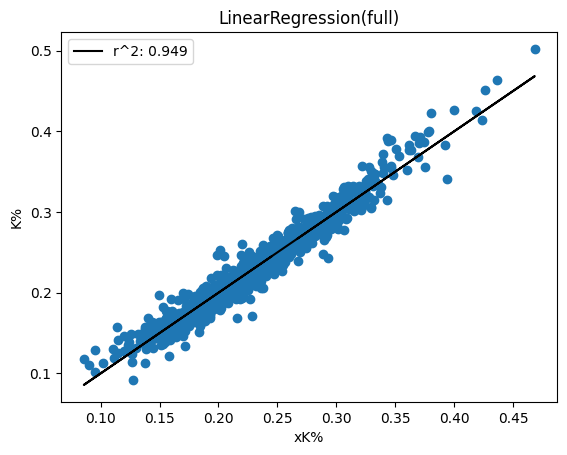

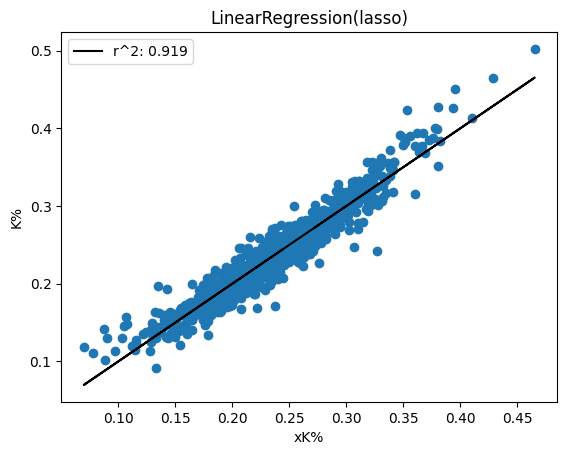

In [56]:
plot_pred_vs_target(lr_preds_full, y_df, "LinearRegression(full)")
plot_pred_vs_target(lr_preds_lasso, y_df, "LinearRegression(lasso)")

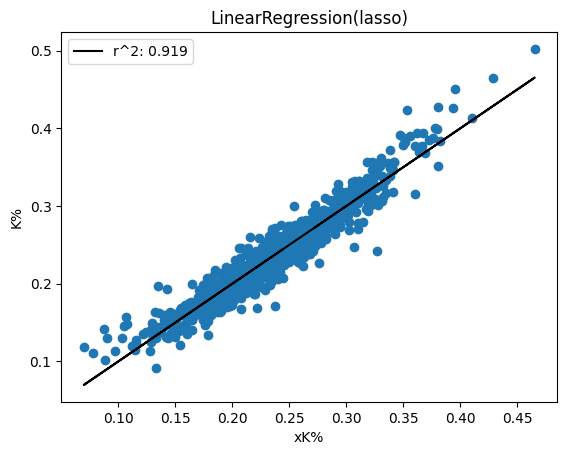

In [51]:
plot_pred_vs_target(lr_preds_lasso, y_df, "LinearRegression(lasso)")

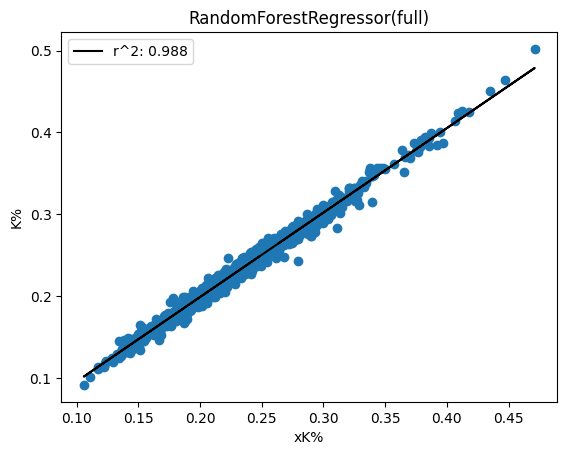

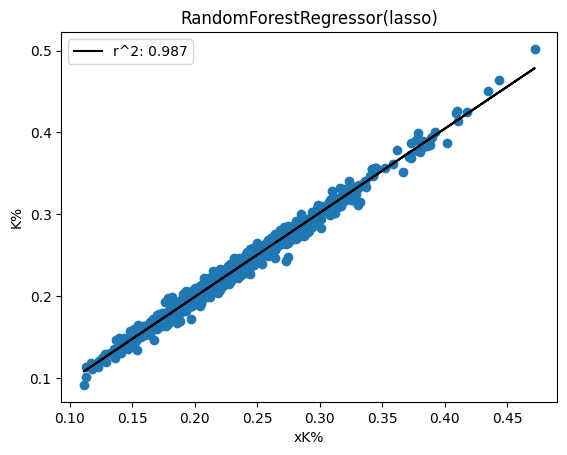

In [57]:
plot_pred_vs_target(rf_preds_full, y_df, "RandomForestRegressor(full)")
plot_pred_vs_target(rf_preds_lasso, y_df, "RandomForestRegressor(lasso)")

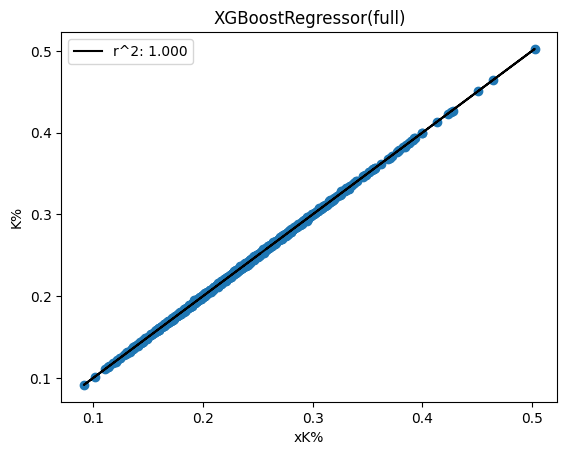

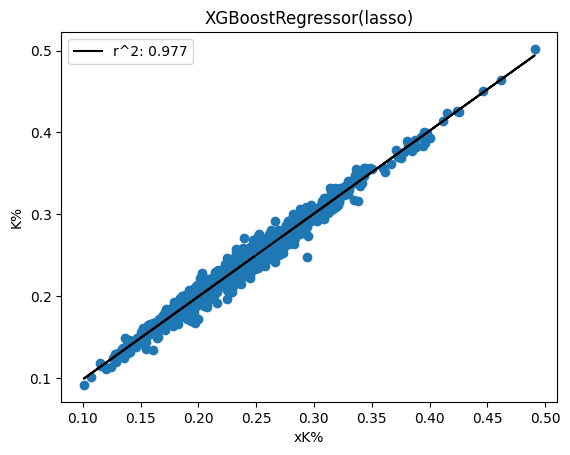

In [58]:
plot_pred_vs_target(xgb_preds_full, y_df, "XGBoostRegressor(full)")
plot_pred_vs_target(xgb_preds_lasso, y_df, "XGBoostRegressor(lasso)")

In [59]:
data = pd.concat([X, y.rename(self.target)], axis=1)

,MLBAMID,PlayerId,Team,Age,Season,TBF,Rk,IP,PA,Pit,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
0,621345,18655,ATL,27,2021,221,696,52.1,221,876,...,44,7,11,46,0.192982,11,4,0,0,0
1,621345,18655,ATL,28,2022,271,649,70.0,272,1111,...,50,2,23,71,0.244681,12,0,0,0,0
2,621345,18655,ATL,29,2023,260,647,64.2,260,1062,...,40,4,13,69,0.158537,8,1,0,0,0
3,640462,19343,OAK,27,2022,281,773,66.1,281,1072,...,48,6,22,54,0.289474,15,4,0,0,0
4,640462,19343,MIA,28,2023,242,755,56.2,242,950,...,42,6,22,56,0.282051,16,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,425844,1943,HOU,37,2021,697,417,171.0,697,2577,...,51,4,34,85,0.285714,13,6,0,0,0
984,425844,1943,KCR,38,2022,585,396,137.0,586,2272,...,39,3,22,51,0.301370,7,2,0,0,0
985,425844,1943,KCR,39,2023,593,353,142.1,595,2221,...,53,6,25,70,0.263158,11,2,0,0,0
986,668868,25918,STL,24,2022,136,967,34.2,137,575,...,40,3,10,17,0.370370,3,2,0,0,0


In [4]:
def plot_player(player_id, train, test, source="mlb", default_year=2024, default_k=0.3):
    """
    defaults used to show blanks only.
    """
    source_col = lookup._check_source(source)
    train_mask = train[source_col] == player_id
    test_mask = test[source_col] == player_id

    name = train.loc[train_mask, "Name"].unique().item()
    seasons = train.loc[train_mask, "Season"].tolist()
    ks = train.loc[train_mask, "K%"].tolist()

    target_year = (
        test.loc[test_mask, "Season"].item() if test_mask.sum() else default_year
    )
    target = test.loc[test_mask, "K%"].item() if test_mask.sum() else default_k
    alpha = None if test_mask.sum() else 0
    title = f"{name} ({source}: {player_id})"
    if not test_mask.sum():
        title = f"{title}\n NO TARGET DATA FOR {target_year}"

    fig, ax = plt.subplots()
    ax.plot(
        pd.to_datetime(seasons, format="%Y"),
        ks,
        marker="s",
        label="Prev Year(s) K%",
    )
    ax.scatter(
        pd.to_datetime(target_year, format="%Y"),
        target,
        marker="o",
        color="g",
        s=50,
        label=f"{target_year} K% (target)",
        alpha=alpha,
    )
    ax.set_ylim([0, 0.51])
    ax.legend()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.set_xlabel("Year")
    ax.set_ylabel("K%")
    ax.set_title(title)
    plt.show();

```mermaid
flowchart TD
    A["Player Pool"]
    A --> B["Training Pool"]
    A --> C["Test Pool"]

    subgraph EvaluationFlow [" "]
        direction LR
        G["2021 --- 2022 --- 2023"] -->|Predict| H["2024"]:::blue
    end
    C -- Evaluation Flow --> G

    subgraph TrainingFlow [" "]
        direction LR
        D["2021 --- 2022"] -->|Predict| E["2023"]:::blue
        F["X 2024"]:::red
    end
    B -- Training Flow --> D

    subgraph CVTimeSeries
        direction TB
        FoldTitle11["Fold1"]:::noBorder
        FoldTitle22["Fold2"]:::noBorder
        FoldTitle33["Fold3"]:::noBorder

        Split11["Split1"]:::noBorder
        Fold11["2021"]:::green
        Fold22["2022"]:::blue
        Fold33["2023"]:::transparent

        Split22["Split2"]:::noBorder
        Fold44["2021"]:::green
        Fold55["2022"]:::green
        Fold66["2023"]:::blue

        Split33["Split3"]:::noBorder
        Fold77["Fold1"]:::transparent
        Fold88["Fold2"]:::transparent
        Fold99["Fold3"]:::transparent

        FoldTitle11 ~~~ Fold11
        FoldTitle22 ~~~ Fold22
        FoldTitle33 ~~~ Fold33

        Split11 ~~~ Split22
        Split22 ~~~ Split33

        Fold11 ~~~ Fold44
        Fold22 ~~~ Fold55
        Fold33 ~~~ Fold66

        Fold44 ~~~ Fold77
        Fold55 ~~~ Fold88
        Fold66 ~~~ Fold99
    end

    subgraph CVClassic
        direction TB
        FoldTitle1["Fold1"]:::noBorder
        FoldTitle2["Fold2"]:::noBorder
        FoldTitle3["Fold3"]:::noBorder

        Split1["Split1"]:::noBorder
        Fold1["Fold1"]:::blue
        Fold2["Fold2"]:::green
        Fold3["Fold3"]:::green

        Split2["Split2"]:::noBorder
        Fold4["Fold1"]:::green
        Fold5["Fold2"]:::blue
        Fold6["Fold3"]:::green

        Split3["Split3"]:::noBorder
        Fold7["Fold1"]:::green
        Fold8["Fold2"]:::green
        Fold9["Fold3"]:::blue

        FoldTitle1 ~~~ Fold1
        FoldTitle2 ~~~ Fold2
        FoldTitle3 ~~~ Fold3

        Split1 ~~~ Split2
        Split2 ~~~ Split3

        Fold1 ~~~ Fold4
        Fold2 ~~~ Fold5
        Fold3 ~~~ Fold6

        Fold4 ~~~ Fold7
        Fold5 ~~~ Fold8
        Fold6 ~~~ Fold9
    end

    TrainingFlow --> CVClassic
    TrainingFlow --> CVTimeSeries

    classDef red fill:#FFCCCC,stroke:#FF0000,stroke-width:2px;
    classDef green fill:#CCFFCC,stroke:#00FF00,stroke-width:2px;
    classDef blue fill:#CCCCFF,stroke:#0000FF,stroke-width:2px;
    classDef noBorder fill:none,stroke:none,color:#000000;
    classDef transparent fill:#FFFFFF,stroke:#FFFFFF,stroke-width:2px,opacity:0;
```

# TODO
- plotly graphs
- other models?
- functions and write ups!